# Starting Notebook: To Classify Mutation Data

In [1]:
!pip install pyfaidx biopython torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.9 MB/s eta 0:00:00


In [2]:
# install torchsummary and torchview
#!pip install pytorch-lightning torchview


In [3]:
import os  # OS interaction
from typing import Tuple  # Type hinting
import itertools
import numpy as np  # Numerical arrays
import pandas as pd  # Data manipulation
import networkx as nx  # Graph creation and analysis
from collections import defaultdict  # Dicts with default values
import matplotlib.pyplot as plt  # Plotting

from sklearn.preprocessing import LabelEncoder  # Label encoding
from sklearn.metrics import precision_recall_fscore_support  # Performance metrics

from pyfaidx import Fasta  # FASTA file handling
from functools import lru_cache  # Function caching

import torch  # Core deep learning library
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # NN functional methods
from torch.utils.data import Dataset  # Custom datasets

from torch_geometric.data import Data, Batch  # Graph data handling
from torch_geometric.nn import GCNConv, global_mean_pool  # GCN layers and pooling
from torch_geometric.nn import GATConv
from torch_geometric.nn import BatchNorm
from torch_geometric.utils import from_networkx  # Convert NetworkX to PyTorch Geometric

#import pytorch_lightning as pl  # High-level PyTorch framework
# from pytorch_lightning.callbacks import EarlyStopping  # Stop training on no improvement

#from torchsummary import summary
#from torchview import draw_graph

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader

from Bio.Seq import reverse_complement


In [4]:
### Specify File Path in Here ###

GENOME_PATH = "/kaggle/input/mutation/hg38.fa"
INPUT_FILEPATH = "/kaggle/input/mutation/Mutation_and_healthy_data.csv"


In [5]:
# variant pathogenecity prediction

In [6]:
# Read the mutation file
df = pd.read_csv(INPUT_FILEPATH, low_memory=False)
df


,gene,chr,pos,ref,alt,variation_id,variant_type,clinical_significance
0,APOA2,1,161223893,G,"A,C,T",SNP:5082,snv,harmful
1,CYP21A2;TNXB,6,32041006,C,T,SNP:6445,snv,harmful
2,CYP21A2,6,32040110,G,"A,C,T",SNP:6471,snv,harmful
3,CYP21A2,6,32039426,T,A,SNP:6475,snv,harmful
4,NPC2,14,74484579,A,G,SNP:11694,snv,harmful
...,...,...,...,...,...,...,...,...
1257092,CDH1,16,68811730,G,"A,C",SNP:778959722,snv,non-harmful
1257093,NF1,17,31330479,T,C,SNP:779114598,snv,non-harmful
1257094,SERAC1,6,158114989,A,"-,AA",SNP:780420200,delins,non-harmful
1257095,PALB2,16,23630072,T,C,SNP:781440401,snv,non-harmful


In [7]:
df[df['ref'].isnull()]


,gene,chr,pos,ref,alt,variation_id,variant_type,clinical_significance
799974,RPL7A;SURF1,9,133351734,NaN,NaN,SNP:879551540,del,non-harmful
1092928,RPL7A;SURF1,9,133351734,NaN,NaN,SNP:879551540,del,non-harmful


In [8]:
out_chroms = ['NW_015148969.2', 'NW_009646203.1', 'NW_009646206.1']
df = df[~df['chr'].isin(out_chroms)]
df = df.drop('variation_id', axis=1).dropna()
df


,gene,chr,pos,ref,alt,variant_type,clinical_significance
0,APOA2,1,161223893,G,"A,C,T",snv,harmful
1,CYP21A2;TNXB,6,32041006,C,T,snv,harmful
2,CYP21A2,6,32040110,G,"A,C,T",snv,harmful
3,CYP21A2,6,32039426,T,A,snv,harmful
4,NPC2,14,74484579,A,G,snv,harmful
...,...,...,...,...,...,...,...
1257092,CDH1,16,68811730,G,"A,C",snv,non-harmful
1257093,NF1,17,31330479,T,C,snv,non-harmful
1257094,SERAC1,6,158114989,A,"-,AA",delins,non-harmful
1257095,PALB2,16,23630072,T,C,snv,non-harmful


In [9]:
df.isnull().sum()


gene                     0
chr                      0
pos                      0
ref                      0
alt                      0
variant_type             0
clinical_significance    0
dtype: int64

In [10]:
df = df[(df['ref'].str.len() == 1) & (df['alt'].str.len() == 1)]
df['variant_type'].value_counts()


variant_type
snv       609919
delins     55071
del        21995
ins         3424
Name: count, dtype: int64

In [11]:
df = df[df['alt'].apply(lambda var: len(var.split(",")) == 1)].reset_index(drop=True)
df['chr'] = df['chr'].replace({'MT': 'M'})
df['chr'].unique()


array(['6', '14', '15', '1', '2', 'X', '7', '17', '4', '11', '12', '8',
       '16', '9', '19', '3', '21', '18', '5', '10', 'M', '20', '22', '13',
       'Y'], dtype=object)

In [12]:
val_count_df = df['clinical_significance'].value_counts()

# Calculate weights for loss function
pos_class_weight = torch.tensor(val_count_df.loc['non-harmful'] / val_count_df.loc['harmful'])
neg_class_weight = torch.tensor(val_count_df.loc['harmful'] / val_count_df.loc['non-harmful'])
class_weight = torch.tensor(val_count_df.loc['harmful'] / val_count_df.sum())

print(f"Positive Class Weight (Harmful): {pos_class_weight:.4f}")
print(f"Negative Class Weight (Non-harmful): {neg_class_weight:.4f}")
print(f"Alpha : {class_weight:.4f}")


Positive Class Weight (Harmful): 3.4904
Negative Class Weight (Non-harmful): 0.2865
Alpha : 0.2227


## Retreiving and Processing Reference and Mutation Sequence

In [13]:
if os.path.exists(f"{GENOME_PATH}.fai"):
    print("Genome Index File Already Exists. Skipping...")
    GENOME = Fasta(GENOME_PATH, rebuild=False)
else:
    print("Indexing Genome Fasta File...")
    #new_genome_path = "/kaggle/working/hg38.fa"
    #!cp $GENOME_PATH "/kaggle/working/"
    GENOME = Fasta(GENOME_PATH, rebuild=True)

# Example Usage
W = 10
pos = 74484579 - 1
GENOME['chr14'][pos-W : pos+W].seq


Genome Index File Already Exists. Skipping...


/usr/local/lib/python3.11/dist-packages/pyfaidx/__init__.py:517: RuntimeWarning: Index file /kaggle/input/mutation/hg38.fa.fai is older than FASTA file /kaggle/input/mutation/hg38.fa.
  warnings.warn(


'CTGCTTTTAGACTGAATATC'

In [14]:
class MutationProcessor:
    def __init__(self, genome, k=3, window=10):
        """
        Initialize the Mutation Processor
        
        Parameters:
        - genome: Reference genome dictionary
        - k: K-mer length for encoding
        - window: Sequence window around mutation
        """
        self.genome = genome
        self.k = k
        self.window = window
        
        # Precompute k-mer dictionary
        self.kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]
        self.kmer_to_index = {kmer: idx for idx, kmer in enumerate(self.kmers)}
    
    @lru_cache(maxsize=1024)
    def get_sequence(self, chrom, start, end):
        """
        Cached sequence retrieval from genome
        
        Parameters:
        - chrom: Chromosome number
        - start: Start position
        - end: End position
        
        Returns:
        - Uppercase sequence
        """
        return str(self.genome[f"chr{chrom}"][start:end]).upper()
    
    def reverse_complement(self, seq):
        """
        Generate reverse complement of a DNA sequence
        
        Parameters:
        - seq: Input DNA sequence
        
        Returns:
        - Reverse complemented sequence
        """
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        return ''.join(complement.get(base, base) for base in reversed(seq))
    
    def kmer_encode(self, sequences):
        """
        Encode sequences using k-mer representation
        
        Parameters:
        - sequences: List of DNA sequences
        
        Returns:
        - Tensor with k-mer encoded representation
        """
        # Pad sequences to ensure consistent length
        max_len = max(len(seq) for seq in sequences)
        padded_sequences = [seq.ljust(max_len, 'N') for seq in sequences]
        
        # Create k-mer encoding
        kmer_encoded = np.zeros(
            (len(sequences), max_len - self.k + 1, len(self.kmers)), 
            dtype=np.float32
        )
        
        for seq_idx, seq in enumerate(padded_sequences):
            for i in range(len(seq) - self.k + 1):
                kmer = seq[i:i+self.k]
                if all(base in 'ACGT' for base in kmer):
                    kmer_idx = self.kmer_to_index[kmer]
                    kmer_encoded[seq_idx, i, kmer_idx] = 1
        
        return torch.from_numpy(kmer_encoded)
    
    def process_mutations(self, df):
        """
        Process mutations for LSTM input
        
        Parameters:
        - df: DataFrame with mutation information
        
        Returns:
        - Tuple of encoded sequences (reference forward, reference reverse, 
          mutated forward, mutated reverse)
        """
        # Extract sequences with extended window
        df['start'] = df['pos'] - self.window - 1
        df['end'] = df['pos'] + self.window
        
        # Retrieve reference sequences
        df['ref_seq'] = df.apply(
            lambda row: self.get_sequence(row['chr'], row['start'], row['end']), 
            axis=1
        )
        
        # Generate mutated sequences
        def generate_mut_seq(row):
            ref_seq = row['ref_seq']
            alt_allele = row['alt']  # Single alternate allele
            return ref_seq[:self.window] + alt_allele + ref_seq[self.window + len(row['ref']):]
        
        df['mut_seq'] = df.apply(generate_mut_seq, axis=1)
        
        # Generate reverse complement sequences
        df['ref_seq_rev'] = df['ref_seq'].apply(self.reverse_complement)
        df['mut_seq_rev'] = df['mut_seq'].apply(self.reverse_complement)
        
        # Prepare sequences for encoding
        ref_seqs = df['ref_seq'].tolist()
        mut_seqs = df['mut_seq'].tolist()
        ref_seqs_rev = df['ref_seq_rev'].tolist()
        mut_seqs_rev = df['mut_seq_rev'].tolist()
        
        # K-mer encode all sequences
        ref_encoded = self.kmer_encode(ref_seqs)
        mut_encoded = self.kmer_encode(mut_seqs)
        ref_rev_encoded = self.kmer_encode(ref_seqs_rev)
        mut_rev_encoded = self.kmer_encode(mut_seqs_rev)
        
        return (ref_encoded, ref_rev_encoded, mut_encoded, mut_rev_encoded)

# Assuming GENOME is your reference genome dictionary
seq_processor = MutationProcessor(GENOME, k=3, window=10)

# Assuming df is your mutation DataFrame
ref_encoded, ref_rev_encoded, mut_encoded, mut_rev_encoded = seq_processor.process_mutations(df)

print(f"Reference shape: {ref_encoded.shape}")
print(f"Mutated shape: {mut_encoded.shape}")
print(f"Reference reverse shape: {ref_rev_encoded.shape}")
print(f"Mutated reverse shape: {mut_rev_encoded.shape}")


Reference shape: torch.Size([690409, 19, 64])
Mutated shape: torch.Size([690409, 19, 64])
Reference reverse shape: torch.Size([690409, 19, 64])
Mutated reverse shape: torch.Size([690409, 19, 64])


In [15]:
df

,gene,chr,pos,ref,alt,variant_type,clinical_significance,start,end,ref_seq,mut_seq,ref_seq_rev,mut_seq_rev
0,CYP21A2;TNXB,6,32041006,C,T,snv,harmful,32040995,32041016,CACGCTGCTGCCCTCCGGGGA,CACGCTGCTGTCCTCCGGGGA,TCCCCGGAGGGCAGCAGCGTG,TCCCCGGAGGACAGCAGCGTG
1,CYP21A2,6,32039426,T,A,snv,harmful,32039415,32039436,TGCAGCATCATCTGTTACCTC,TGCAGCATCAACTGTTACCTC,GAGGTAACAGATGATGCTGCA,GAGGTAACAGTTGATGCTGCA
2,NPC2,14,74484579,A,G,snv,harmful,74484568,74484589,CTGCTTTTAGACTGAATATCT,CTGCTTTTAGGCTGAATATCT,AGATATTCAGTCTAAAAGCAG,AGATATTCAGCCTAAAAGCAG
3,FBN1,15,48613073,G,A,snv,harmful,48613062,48613083,GCATTATAACGTGATCCACAG,GCATTATAACATGATCCACAG,CTGTGGATCACGTTATAATGC,CTGTGGATCATGTTATAATGC
4,FBN1,15,48487317,C,T,snv,harmful,48487306,48487327,CTTACCGATACACGCGGAGAT,CTTACCGATATACGCGGAGAT,ATCTCCGCGTGTATCGGTAAG,ATCTCCGCGTATATCGGTAAG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
690404,ATM,11,108272787,A,G,snv,non-harmful,108272776,108272797,TAAATGAAGTATTTACACAAT,TAAATGAAGTGTTTACACAAT,ATTGTGTAAATACTTCATTTA,ATTGTGTAAACACTTCATTTA
690405,BRCA1,17,43094544,A,G,snv,non-harmful,43094533,43094554,TCCGCCTATCATTACATGTTT,TCCGCCTATCGTTACATGTTT,AAACATGTAATGATAGGCGGA,AAACATGTAACGATAGGCGGA
690406,MUTYH,1,45334470,G,A,snv,non-harmful,45334459,45334480,CCTGCTTCCTGTGACCACTTC,CCTGCTTCCTATGACCACTTC,GAAGTGGTCACAGGAAGCAGG,GAAGTGGTCATAGGAAGCAGG
690407,NF1,17,31330479,T,C,snv,non-harmful,31330468,31330489,AAGAGTGTATTTCTGGATTTA,AAGAGTGTATCTCTGGATTTA,TAAATCCAGAAATACACTCTT,TAAATCCAGAGATACACTCTT


## Encode Categorical Features

In [16]:
# Encode 'chr' column
df['chr_encoded'] = df['chr'].replace({'X' : 23, 'Y' : 24, 'M' : 25, 'NW_009646206.1' : 26,
            'NW_009646201.1' : 27, 'NW_009646203.1' : 28, 'NW_015148969.2': 29}).astype(int)

# Initialize LabelEncoders
gene_encoder = LabelEncoder()
ref_encoder = LabelEncoder()
alt_encoder = LabelEncoder()
#variation_encoder = LabelEncoder()
variant_type_encoder = LabelEncoder()
clinical_significance_encoder = LabelEncoder()

# Fit and transform the categorical data
df['gene_encoded'] = gene_encoder.fit_transform(df['gene'])
df['ref_encoded'] = ref_encoder.fit_transform(df['ref'])
df['alt_encoded'] = alt_encoder.fit_transform(df['alt'])
#df['variation'] = variation_encoder.fit_transform(df['variation'])
df['variant_type_encoded'] = variant_type_encoder.fit_transform(df['variant_type'])
df['clinical_significance_encoded'] = clinical_significance_encoder.fit_transform(df['clinical_significance'])
df


,gene,chr,pos,ref,alt,variant_type,clinical_significance,start,end,ref_seq,mut_seq,ref_seq_rev,mut_seq_rev,chr_encoded,gene_encoded,ref_encoded,alt_encoded,variant_type_encoded,clinical_significance_encoded
0,CYP21A2;TNXB,6,32041006,C,T,snv,harmful,32040995,32041016,CACGCTGCTGCCCTCCGGGGA,CACGCTGCTGTCCTCCGGGGA,TCCCCGGAGGGCAGCAGCGTG,TCCCCGGAGGACAGCAGCGTG,6,2819,2,4,3,0
1,CYP21A2,6,32039426,T,A,snv,harmful,32039415,32039436,TGCAGCATCATCTGTTACCTC,TGCAGCATCAACTGTTACCTC,GAGGTAACAGATGATGCTGCA,GAGGTAACAGTTGATGCTGCA,6,2818,4,1,3,0
2,NPC2,14,74484579,A,G,snv,harmful,74484568,74484589,CTGCTTTTAGACTGAATATCT,CTGCTTTTAGGCTGAATATCT,AGATATTCAGTCTAAAAGCAG,AGATATTCAGCCTAAAAGCAG,14,7922,1,3,3,0
3,FBN1,15,48613073,G,A,snv,harmful,48613062,48613083,GCATTATAACGTGATCCACAG,GCATTATAACATGATCCACAG,CTGTGGATCACGTTATAATGC,CTGTGGATCATGTTATAATGC,15,4032,3,1,3,0
4,FBN1,15,48487317,C,T,snv,harmful,48487306,48487327,CTTACCGATACACGCGGAGAT,CTTACCGATATACGCGGAGAT,ATCTCCGCGTGTATCGGTAAG,ATCTCCGCGTATATCGGTAAG,15,4032,2,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690404,ATM,11,108272787,A,G,snv,non-harmful,108272776,108272797,TAAATGAAGTATTTACACAAT,TAAATGAAGTGTTTACACAAT,ATTGTGTAAATACTTCATTTA,ATTGTGTAAACACTTCATTTA,11,964,1,3,3,1
690405,BRCA1,17,43094544,A,G,snv,non-harmful,43094533,43094554,TCCGCCTATCATTACATGTTT,TCCGCCTATCGTTACATGTTT,AAACATGTAATGATAGGCGGA,AAACATGTAACGATAGGCGGA,17,1292,1,3,3,1
690406,MUTYH,1,45334470,G,A,snv,non-harmful,45334459,45334480,CCTGCTTCCTGTGACCACTTC,CCTGCTTCCTATGACCACTTC,GAAGTGGTCACAGGAAGCAGG,GAAGTGGTCATAGGAAGCAGG,1,7354,3,1,3,1
690407,NF1,17,31330479,T,C,snv,non-harmful,31330468,31330489,AAGAGTGTATTTCTGGATTTA,AAGAGTGTATCTCTGGATTTA,TAAATCCAGAAATACACTCTT,TAAATCCAGAGATACACTCTT,17,7749,4,2,3,1


## Build Graph

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


In [18]:
def build_gene_graph(df, pos_window=1e5, min_edge_weight=1):
    """
    Build a gene graph using one biological rule:
    clinical_significance + chr + variant_type + ref>alt + pos ± pos_window
    
    Returns:
        - nodes: list of gene names
        - edges: list of (gene1, gene2, weight)
        - graph: networkx.Graph object
    """
    df = df.copy()
    df['mut'] = df['ref'] + '>' + df['alt']
    
    # Initialize graph with all unique genes
    genes = df['gene'].unique()
    G = nx.Graph()
    G.add_nodes_from(genes)
    
    edge_weights = {}

    # Group by the new unified rule
    for (sig, chr_val, var_type, mut_val), group in df.groupby(['clinical_significance', 'chr', 'variant_type', 'mut']):
        if len(group) < 2:
            continue  # Skip singleton groups (only one gene with this variant type)

        # Get unique gene-position pairs
        gene_pos = group[['gene', 'pos']].drop_duplicates().values  # NumPy array

        # Generate combinations of gene pairs (avoids duplicate pairs, e.g., gene1-gene2 vs gene2-gene1)
        for (gene1, pos1), (gene2, pos2) in combinations(gene_pos, 2):
            if abs(pos1 - pos2) <= pos_window:  # Check if the positions are within the specified window
                edge = (gene1, gene2)
                edge_weights[edge] = edge_weights.get(edge, 0) + 1

    # Apply minimum edge weight filter
    for (g1, g2), weight in edge_weights.items():
        if weight >= min_edge_weight:
            G.add_edge(g1, g2, weight=weight)

    #nodes = list(G.nodes())
    #edges = [(u, v, G[u][v]['weight']) for u, v in G.edges()]

    return G


In [19]:
def build_pyg_from_graph(G):
    # Add node features and labels to NetworkX graph
    # Default features: just use a simple scalar feature (node degree)
    degrees = {node: {'x': G.degree(node)} for node in G.nodes()}
    nx.set_node_attributes(G, degrees)
    
    # Handle node labels
    # Default: no labels (zeros)
    #labels = {node: {'y': 0} for node in G.nodes()}
    #nx.set_node_attributes(G, labels)
    
    # Convert to PyG format using from_networkx
    # This automatically handles the node features and edge attributes
    graph_data = from_networkx(G, group_node_attrs=['x'], group_edge_attrs=['weight'])
    
    # Make sure the node label is correctly formatted
    #if 'y' not in graph_data:
    #    graph_data.y = torch.zeros(graph_data.num_nodes, dtype=torch.long)
    
    return graph_data


In [20]:
# Assume df is your DataFrame with columns:
# ['gene', 'chr', 'pos', 'ref', 'alt', 'variant_type', 'clinical_significance']

graph = build_gene_graph(df, pos_window=1e5)

# Inspect
#print(nx.info(graph))
print(graph.nodes['BRCA1'])  # Example
#print(graph.edges(data=True))  # Check edge weights


{}


In [21]:
# Build PyG graph
graph_data = build_pyg_from_graph(graph)

# Print info
print("PyG Data Object:")
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Number of node features: {graph_data.num_features}")
print(f"Edge index shape: {graph_data.edge_index.shape}")
print(f"Node features shape: {graph_data.x.shape}")
#print(f"Node labels shape: {graph_data.y.shape}")


PyG Data Object:
Number of nodes: 13398
Number of edges: 40794
Number of node features: 1
Edge index shape: torch.Size([2, 40794])
Node features shape: torch.Size([13398, 1])


In [22]:
graph_data.x


tensor([[18],
        [18],
        [ 7],
        ...,
        [ 0],
        [ 2],
        [ 1]])

In [23]:
#STOP

In [24]:
def visualize_graph(graph_data):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    G = nx.Graph()

    # Add nodes with features as attributes
    for i in range(graph_data.x.size(0)):
        G.add_node(i, features=graph_data.x[i].numpy(), label=graph_data.y[i].item())

    # Add edges
    edge_index = graph_data.edge_index.numpy()
    print(edge_index)
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    node_labels = {i: G.nodes[i]['label'] for i in G.nodes}  # Extract labels
    node_colors = [G.nodes[i]['label'] for i in G.nodes]  # Optional: use labels for colors

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=10)
    plt.title('Graph Visualization')
    plt.show()

# Usage
#visualize_graph(graph_data)


# Building Model (GCN+LSTM)

In [25]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        return F.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)


In [26]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [27]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = 'mean', eps: float = 1e-7):
        """
        Numerically stable Binary Focal Loss implementation.
        
        Args:
            alpha (float): Weighting factor for the rare class (default: 0.25)
            gamma (float): Focusing parameter (default: 2.0)
            reduction (str): Specifies the reduction: 'none' | 'mean' | 'sum'
            eps (float): Small constant for numerical stability
        """
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Calculate focal loss with improved numerical stability.
        
        Args:
            inputs (torch.Tensor): Model predictions after sigmoid (B, 1)
            targets (torch.Tensor): Ground truth labels (B, 1)
        
        Returns:
            torch.Tensor: Computed focal loss
        """
        # Check for NaN inputs
        if torch.isnan(inputs).any() or torch.isnan(targets).any():
            raise ValueError("Input or target contains NaN values")
            
        # Ensure inputs are in valid range
        inputs = torch.clamp(inputs, self.eps, 1.0 - self.eps)
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()
        
        # Calculate BCE loss safely
        bce_loss = -(targets * torch.log(inputs + self.eps) + 
                    (1 - targets) * torch.log(1 - inputs + self.eps))
        
        # Calculate weights
        p_t = torch.where(targets == 1, inputs, 1 - inputs)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        
        # Calculate focal term more safely
        focal_term = (1 - p_t) ** self.gamma
        
        # Combine terms
        loss = alpha_t * focal_term * bce_loss
        
        # Check for invalid values
        if torch.isnan(loss).any():
            print("Warning: NaN in loss calculation")
            print(f"inputs min/max: {inputs.min().item():.6f}/{inputs.max().item():.6f}")
            print(f"p_t min/max: {p_t.min().item():.6f}/{p_t.max().item():.6f}")
            print(f"bce_loss min/max: {bce_loss.min().item():.6f}/{bce_loss.max().item():.6f}")
            loss = torch.where(torch.isnan(loss), torch.full_like(loss, 0), loss)
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def initialize_training(model, learning_rate=1e-3, weight_decay=1e-5):
    """
    Initialize training components with safer defaults
    """
    criterion = BinaryFocalLoss(
        alpha=class_weight,
        gamma=2.0,
        reduction='mean')
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        eps=1e-8)
    
    # Optional: Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=True)
    
    return criterion, optimizer, scheduler


In [28]:
class GCNLSTMDataset(Dataset):
    def __init__(self, graph_data, ref_encoded, ref_rev_encoded, mut_encoded, mut_rev_encoded, labels):
        self.graph_x = graph_data.x.float()
        self.graph_edge_index = graph_data.edge_index
        self.ref_seq = ref_encoded
        self.mut_seq = mut_encoded
        self.ref_rev_seq = ref_rev_encoded
        self.mut_rev_seq = mut_rev_encoded
        self.y = labels
        
    def __len__(self):
        return self.y.shape[0]
        
    def __getitem__(self, idx):
        return Data(
            x=self.graph_x,
            edge_index=self.graph_edge_index,
            y=self.y[idx],
            ref_seq=self.ref_seq[idx],
            ref_rev_seq=self.ref_rev_seq[idx],
            mut_seq=self.mut_seq[idx],
            mut_rev_seq=self.mut_rev_seq[idx])

def collate_fn(batch):
    ref_seqs = torch.stack([item.ref_seq for item in batch])
    mut_seqs = torch.stack([item.mut_seq for item in batch])
    ref_rev_seqs = torch.stack([item.ref_rev_seq for item in batch])
    mut_rev_seqs = torch.stack([item.mut_rev_seq for item in batch])
    #labels = torch.stack([item.y for item in batch])
    labels = torch.stack([torch.tensor(item.y) for item in batch])
    
    graph_data = Data(
        x=batch[0].x,
        edge_index=batch[0].edge_index,
        y=labels,
        ref_seq=ref_seqs,
        ref_rev_seq=ref_rev_seqs,
        mut_rev_seq=mut_rev_seqs,
        mut_seq=mut_seqs,
        batch=torch.zeros(batch[0].x.size(0), dtype=torch.long))
    
    return graph_data

def create_data_loaders(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    # Extract labels
    labels = dataset.y

    # Initialize StratifiedShuffleSplit for train/test+val split
    splitter_1 = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=42)
    
    # Get train and temp indices
    for train_idx, temp_idx in splitter_1.split(torch.arange(len(labels)), labels):
        train_dataset = Subset(dataset, train_idx)
        temp_labels = labels[temp_idx]
    
    # Initialize StratifiedShuffleSplit for validation/test split
    splitter_2 = StratifiedShuffleSplit(n_splits=1, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)
    
    # Get validation and test indices
    for val_idx, test_idx in splitter_2.split(torch.arange(len(temp_labels)), temp_labels):
        val_dataset = Subset(dataset, temp_idx[val_idx])
        test_dataset = Subset(dataset, temp_idx[test_idx])
    
    # Print dataset sizes for verification
    print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}, Test set size: {len(test_dataset)}")
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return (train_loader, val_loader, test_loader)
    

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, input_dim),
                nn.Tanh(),
                nn.Linear(input_dim, 1, bias=False)
            ) for _ in range(num_heads)
        ])
        self.output_projection = nn.Linear(num_heads * input_dim, input_dim)

    def forward(self, lstm_output):
        head_outputs = []
        for head in self.attention_heads:
            attention_scores = head(lstm_output).squeeze(-1)
            attention_weights = F.softmax(attention_scores, dim=1)
            context = torch.sum(attention_weights.unsqueeze(-1) * lstm_output, dim=1)
            head_outputs.append(context)
        
        combined = torch.cat(head_outputs, dim=-1)
        return self.output_projection(combined)

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate, l2_reg):
        super().__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        
        # Optional projection for residual connection if dimensions differ
        self.shortcut = (nn.Linear(in_features, out_features) 
                         if in_features != out_features else nn.Identity())
        
        # L2 Regularization
        self.l2_reg = l2_reg

    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.linear2(out)
        out = self.bn2(out)
        
        # Residual connection
        out += identity
        out = F.relu(out)
        
        # L2 Regularization (can be applied during training)
        if self.l2_reg > 0:
            l2_loss = sum(p.pow(2).sum() for p in self.parameters())
            out = out - self.l2_reg * l2_loss
        
        return out


In [30]:
class GCNLSTMHybrid(nn.Module):
    def __init__(self, 
                 num_node_features: int,
                 kmer_length: int,
                 gcn_hidden_channels: list = [32, 64, 128],
                 lstm_hidden_size: int = 64, 
                 lstm_num_layers: int = 3, 
                 dropout_rate: float = 0.2):
        super().__init__()
        
        # Modular GCN Layers using nn.ModuleList
        self.gcn_layers = nn.ModuleList([
            GCNConv(
                in_channels=num_node_features if i == 0 else gcn_hidden_channels[i-1], 
                out_channels=gcn_hidden_channels[i]
            ) for i in range(len(gcn_hidden_channels))
        ])
        
        # Batch Normalization Layers
        self.batch_norm_layers = nn.ModuleList([
            nn.BatchNorm1d(channels) for channels in gcn_hidden_channels
        ])
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=kmer_length, 
            hidden_size=lstm_hidden_size, 
            num_layers=lstm_num_layers, 
            batch_first=True,
            bidirectional=True
        )
        
        # Simplified Attention
        #self.attention = nn.Linear(lstm_hidden_size, 1)
        self.attention = nn.Sequential(
                nn.Linear(lstm_hidden_size * 2, lstm_hidden_size),  # Note the * 2 for bidirectional
                nn.ReLU(),
                nn.Linear(lstm_hidden_size, 1))
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        # Types of seq
        self.seq_types = ['ref_seq', 'mut_seq', 'ref_rev_seq', 'mut_rev_seq']
        
        # Dynamically calculate total feature size
        total_feature_size = (
            gcn_hidden_channels[-1] +  # GCN pooled features
            (2 * lstm_hidden_size * len(self.seq_types))  # LSTM contexts (bidirectional * number of sequences)
        )
        
        # Then update FC layers accordingly
        self.fc = nn.Sequential(
            nn.Linear(total_feature_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def attention_mechanism(self, lstm_output):
        # Reshape lstm_output to match attention layer input
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # Reshape to [batch_size * seq_len, hidden_size]
        lstm_output_reshaped = lstm_output.contiguous().view(-1, hidden_size)
        
        # Compute attention scores
        attention_scores = self.attention(lstm_output_reshaped)
        
        # Reshape back to [batch_size, seq_len]
        attention_scores = attention_scores.view(batch_size, seq_len)
        
        # Apply softmax
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Apply attention
        context = torch.sum(attention_weights.unsqueeze(-1) * lstm_output, dim=1)
        
        return context

    def forward(self, data):
        # GCN Forward Pass with Modular Layers
        x = data.x
        for i, (gcn_layer, batch_norm) in enumerate(zip(self.gcn_layers, self.batch_norm_layers)):
            x = gcn_layer(x, data.edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)

        x = global_mean_pool(x, data.batch)  # GCN pooled features
        #print(f"GCN pooled features shape: {x.shape}")
        
        lstm_contexts = []
        for seq_type in self.seq_types:
            seq_data = getattr(data, seq_type).float()
            lstm_output, _ = self.lstm(seq_data)
            context = self.attention_mechanism(lstm_output)
            lstm_contexts.append(context)
            #print(f"LSTM context for {seq_type}: {context.shape}")

        x = x.repeat(lstm_contexts[0].size(0), 1)
        combined = torch.cat([x] + lstm_contexts, dim=-1)
        #print(f"Combined feature shape: {combined.shape}")

        # Ensure tensors have consistent batch size
        lstm_contexts = [context.view(x.size(0), -1) for context in lstm_contexts]
        
        # Combine Features
        combined = torch.cat([x] + lstm_contexts, dim=-1)
        
        # Final Classification
        out = self.fc(combined)
        return torch.sigmoid(out)


In [31]:
def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                device: torch.device,
                model_save_path: str = 'best_model.pth',
                num_epochs: int = 25,
                patience: int = 7,
                verbose: bool = True):
    
    # Prepare model directory
    os.makedirs(os.path.dirname(model_save_path) or '.', exist_ok=True)
    
    # Log training start
    if verbose:
        print("\n--- Model Training Started ---")
        print(f"Total Epochs: {num_epochs}")
        print(f"Patience: {patience}")
        print(f"Device: {device}")
        print(f"Model will be saved to: {model_save_path}\n")
    
    # Initialize the training components
    criterion, optimizer, scheduler = initialize_training(model, learning_rate=1e-3, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=patience)
    
    max_grad_norm = 1.0
    best_val_loss = float('inf')
    best_model_state = None
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            num_batches = 0
            num_samples = 0
            
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out.squeeze(), batch.y.float())
                loss.backward()
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                train_loss += loss.item()
                num_batches += 1
                # Calculate accuracy
                preds = (out.squeeze() >= 0.5).float()  # Assuming binary classification
                train_correct += (preds == batch.y.float()).sum().item()
                num_samples += batch.y.size(0)
            
            avg_train_loss = train_loss / num_batches
            train_accuracy = train_correct / num_samples
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            num_val_batches = 0
            num_val_samples = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    out = model(batch)
                    loss = criterion(out.squeeze(), batch.y.float())
                    val_loss += loss.item()
                    num_val_batches += 1
                    # Calculate accuracy
                    preds = (out.squeeze() >= 0.5).float()
                    val_correct += (preds == batch.y.float()).sum().item()
                    num_val_samples += batch.y.size(0)
            
            avg_val_loss = val_loss / num_val_batches
            val_accuracy = val_correct / num_val_samples
            
            # Learning rate scheduling
            scheduler.step(avg_val_loss)
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()
                
                # Save the best model
                torch.save({
                    'model_state_dict': best_model_state,
                    'epoch': epoch,
                    'best_val_loss': best_val_loss
                }, model_save_path)
                
                if verbose:
                    print(f"✨ New Best Model Saved at Epoch {epoch+1}")
            
            # Update history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_accuracy)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_accuracy)
            history['learning_rates'].append(optimizer.param_groups[0]['lr'])
            
            if verbose:
                print(f'Epoch {epoch+1}/{num_epochs}:')
                print(f'Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}')
                print(f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')
                print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')
            
            # Early stopping
            early_stopping(avg_val_loss)
            if early_stopping.early_stop:
                if verbose:
                    print("Early stopping triggered")
                break
    
    except Exception as e:
        print(f"Training interrupted due to error: {e}")
        raise
    
    finally:
        # Load best model if available
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        if verbose:
            print("\n--- Model Training Completed ---")
            print(f"Best Validation Loss: {best_val_loss:.4f}")
            print(f"Model saved to: {model_save_path}")
    
    return model, history


In [32]:
# When initializing
torch.cuda.empty_cache()  # Clear GPU memory

# Initialize dataset and loaders
dataset = GCNLSTMDataset(graph_data, ref_encoded, ref_rev_encoded, mut_encoded, mut_rev_encoded, df['clinical_significance_encoded'])
BATCH_SIZE = 32
train_loader, val_loader, test_loader = create_data_loaders(dataset,
                                                            train_ratio=0.7,
                                                            val_ratio=0.15,
                                                            test_ratio=0.15,
                                                            batch_size=BATCH_SIZE)
# Set Model Parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_NODE_FEATURES = graph_data.x.size(1)
SEQ_LENGTH = ref_encoded.size(1)
KMER_LENGTH = len(seq_processor.kmers)

# Initialize model
model = GCNLSTMHybrid(
                num_node_features=NUM_NODE_FEATURES,
                kmer_length=KMER_LENGTH,
                gcn_hidden_channels=[32, 64],  # Experiment with dimensions
                lstm_hidden_size=64,  # Try 32, 64, 128
                lstm_num_layers=3,    # Try 1, 2, 3
                dropout_rate=0.2,     # Grid search: 0.1, 0.2, 0.3, 0.4
            )
model = model.to(DEVICE)

# Train the model
trained_model, training_history = train_model(model, 
                                              train_loader, 
                                              val_loader, 
                                              DEVICE, 
                                              model_save_path='best_gcn_lstm_model.pth',
                                              num_epochs=25, 
                                              patience=7,
                                              verbose=True)


Training set size: 483286, Validation set size: 103561, Test set size: 103562

--- Model Training Started ---
Total Epochs: 25
Patience: 7
Device: cuda
Model will be saved to: best_gcn_lstm_model.pth



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✨ New Best Model Saved at Epoch 1
Epoch 1/25:
Training Loss: 0.0492 | Training Accuracy: 0.7345
Validation Loss: 0.0460 | Validation Accuracy: 0.8056
Learning Rate: 0.001000

✨ New Best Model Saved at Epoch 2
Epoch 2/25:
Training Loss: 0.0442 | Training Accuracy: 0.7717
Validation Loss: 0.0420 | Validation Accuracy: 0.7990
Learning Rate: 0.001000

✨ New Best Model Saved at Epoch 3
Epoch 3/25:
Training Loss: 0.0422 | Training Accuracy: 0.7864
Validation Loss: 0.0411 | Validation Accuracy: 0.7914
Learning Rate: 0.001000

✨ New Best Model Saved at Epoch 4
Epoch 4/25:
Training Loss: 0.0412 | Training Accuracy: 0.7935
Validation Loss: 0.0403 | Validation Accuracy: 0.8164
Learning Rate: 0.001000

✨ New Best Model Saved at Epoch 5
Epoch 5/25:
Training Loss: 0.0403 | Training Accuracy: 0.7977
Validation Loss: 0.0399 | Validation Accuracy: 0.7887
Learning Rate: 0.001000

Epoch 6/25:
Training Loss: 0.0396 | Training Accuracy: 0.7999
Validation Loss: 0.0400 | Validation Accuracy: 0.8195
Learning 

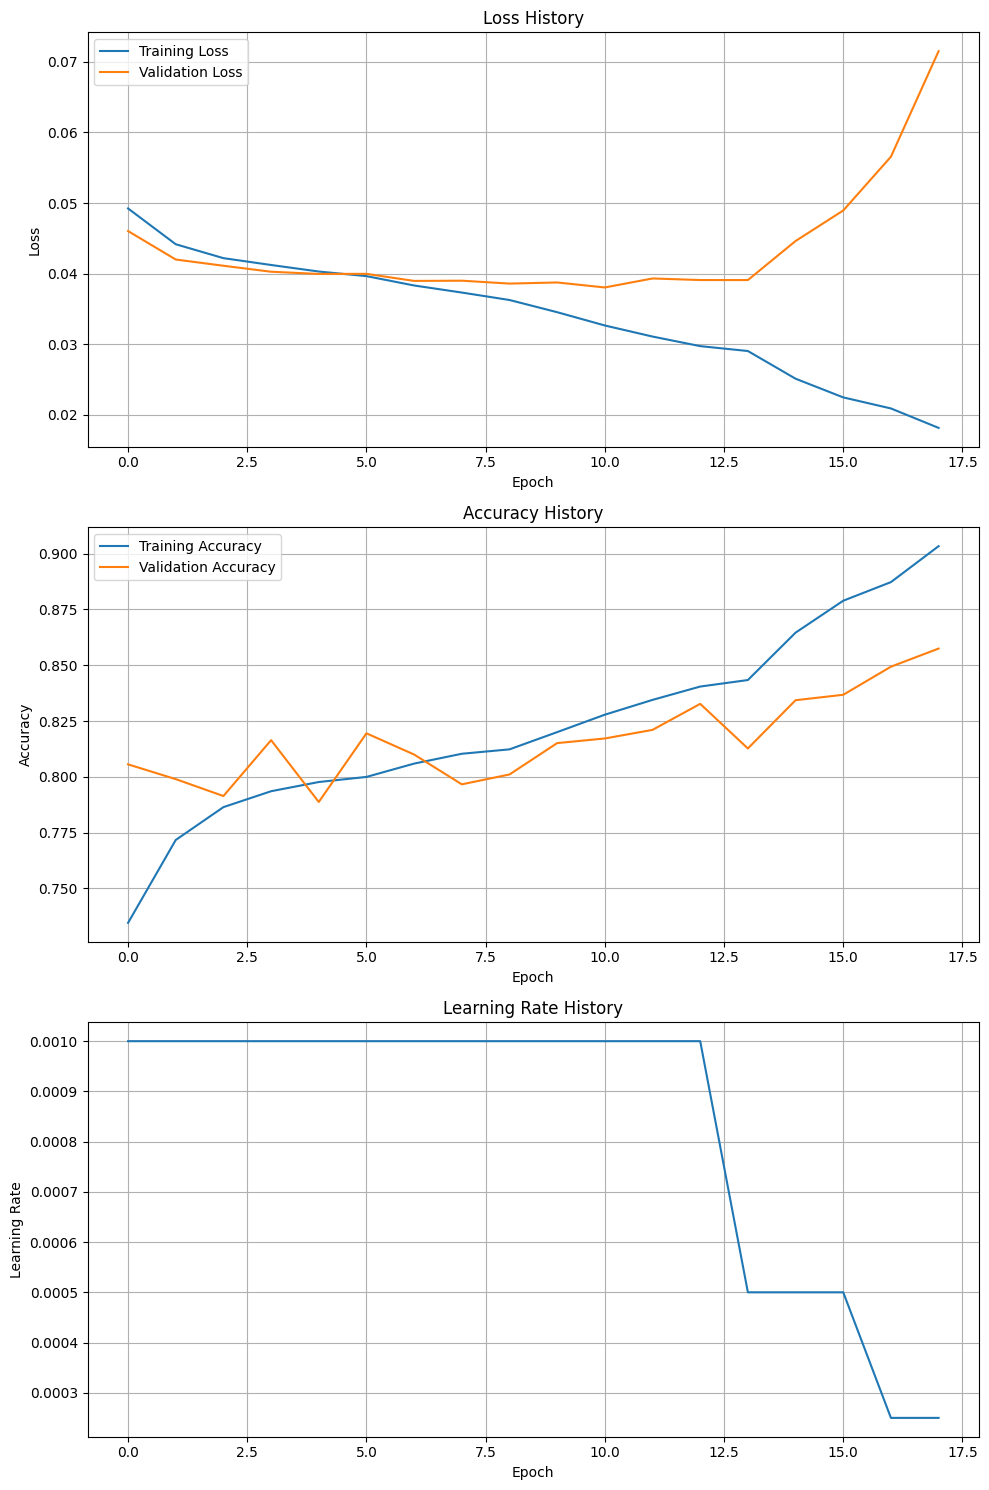

In [33]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot training metrics history
    """
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rate
    ax3.plot(history['learning_rates'])
    ax3.set_title('Learning Rate History')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)


In [34]:
def evaluate_model(model: nn.Module, 
                  test_loader: torch.utils.data.DataLoader, 
                  device: torch.device) -> Tuple[float, float, float, float]:
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = (out.squeeze() > 0.5).float()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    accuracy = (all_preds == all_labels).mean()
    
    return accuracy, precision, recall, f1


# Evaluate model
accuracy, precision, recall, f1 = evaluate_model(trained_model, test_loader, DEVICE)
print(f'Test Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Test Metrics:
Accuracy: 0.8582
Precision: 0.9449
Recall: 0.8683
F1 Score: 0.9050
